In [35]:
import pandas as pd

# Load the CSV file into a DataFrame and parse 'Date' as datetime
df = pd.read_csv('CombinedBeansPrice.csv', parse_dates=['Date'])

# Define a function to calculate the median of a price range
def calculate_median_price(price_range):
    if isinstance(price_range, str):
        # Replace double hyphens with a single hyphen
        price_range = price_range.replace('--', '-')
        
        # Check if the cleaned price_range contains a '-'
        if '-' in price_range:
            # Split the price range by the hyphen
            prices = price_range.split('-')
            
            try:
                # Convert the split strings to floats and calculate the median
                lower_bound = float(prices[0].strip())
                upper_bound = float(prices[1].strip())
                median_price = (lower_bound + upper_bound) / 2
                return median_price
            except ValueError:
                # Handle cases where conversion to float fails
                return float('nan')
    # If the value is not a string or doesn't contain a hyphen, return NaN
    return float('nan')

# Apply the function to the 'Kandy' column and create a new 'Bean_Kandy_price' column
df['Bean_Kandy_price'] = df['Kandy'].apply(calculate_median_price)

# Create a new DataFrame with only the 'Date' and 'Bean_Kandy_price' columns
df_new = df[['Date', 'Bean_Kandy_price']]

# Set 'Date' as the index
df_new.set_index('Date', inplace=True)

# Check for duplicate dates
if df_new.index.duplicated().any():
    print("Duplicate dates found. Removing duplicates.")
    # Aggregate duplicates by taking the mean of the prices
    df_new = df_new.groupby(df_new.index).mean()

# Define the start and end date for the range
start_date = '2020-01-01'
end_date = df_new.index.max()  # Or specify a fixed end date, e.g., '2023-01-01'

# Create a complete date range from start_date to end_date
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame to include all dates in the range
df_reindexed = df_new.reindex(full_date_range)

# Perform interpolation to fill missing values
df_reindexed['Bean_Kandy_price'] = df_reindexed['Bean_Kandy_price'].interpolate(method='linear')

# Reset index to make 'Date' a column again
df_new = df_reindexed.reset_index()
df_new.rename(columns={'index': 'Date'}, inplace=True)

# Display the first few rows of the new DataFrame
print(df_new.head())

# Save the new DataFrame to a CSV file
df_new.to_csv('bean-interpolated.csv', index=False)

print("New CSV file 'beans-interpolated.csv' has been created with interpolated values.")


Duplicate dates found. Removing duplicates.
        Date  Bean_Kandy_price
0 2020-01-01               NaN
1 2020-01-02               NaN
2 2020-01-03               NaN
3 2020-01-04               NaN
4 2020-01-05               NaN
New CSV file 'beans-interpolated.csv' has been created with interpolated values.


In [25]:
df_a = pd.read_csv('bean-interpolated.csv', parse_dates=['Date'], index_col='Date')

# Load the data from dollar-carrot.csv
df_dollar_carrot = pd.read_csv('Dollar-Carrot.csv', parse_dates=['Date'], index_col='Date')
# Display the first few rows of the dataframes
print("First few rows of a.csv:")
print(df_a.head())
print("\nFirst few rows of dollar-carrot.csv:")
print(df_dollar_carrot.head())

# Merge the dataframes on the 'date' column
# Assuming 'dollar-carrot.csv' contains columns such as 'dollar_rate_carrot' or similar to avoid naming conflicts
df_merged = df_a.merge(df_dollar_carrot, on='Date', how='inner')

# Display the first few rows of the merged and filtered dataframe
print("\nFirst few rows of the merged and filtered dataframe:")
print(df_merged.head())

# Display the column names of the merged dataframe
print("Column names in df_merged:", df_merged.columns)

# Save the filtered dataframe to 'beans-dollar.csv'
# df_merged.to_csv('beannnns-dollar.csv', index=False)

print("Filtered CSV file 'beans-dollar.csv' has been created.")




First few rows of a.csv:
            Bean_Kandy_price
Date                        
2020-01-01              95.0
2020-01-02              95.0
2020-01-03              95.0
2020-01-04              95.0
2020-01-05              95.0

First few rows of dollar-carrot.csv:
             Kandy  Dambulla  Exchange Rate
Date                                       
2020-01-01  296.43     305.0         181.50
2020-01-02  267.86     272.5         181.03
2020-01-03  239.29     240.0         181.37
2020-01-04  210.71     207.5         181.35
2020-01-05  182.14     175.0         181.34

First few rows of the merged and filtered dataframe:
            Bean_Kandy_price   Kandy  Dambulla  Exchange Rate
Date                                                         
2020-01-01              95.0  296.43     305.0         181.50
2020-01-02              95.0  267.86     272.5         181.03
2020-01-03              95.0  239.29     240.0         181.37
2020-01-04              95.0  210.71     207.5         181.35


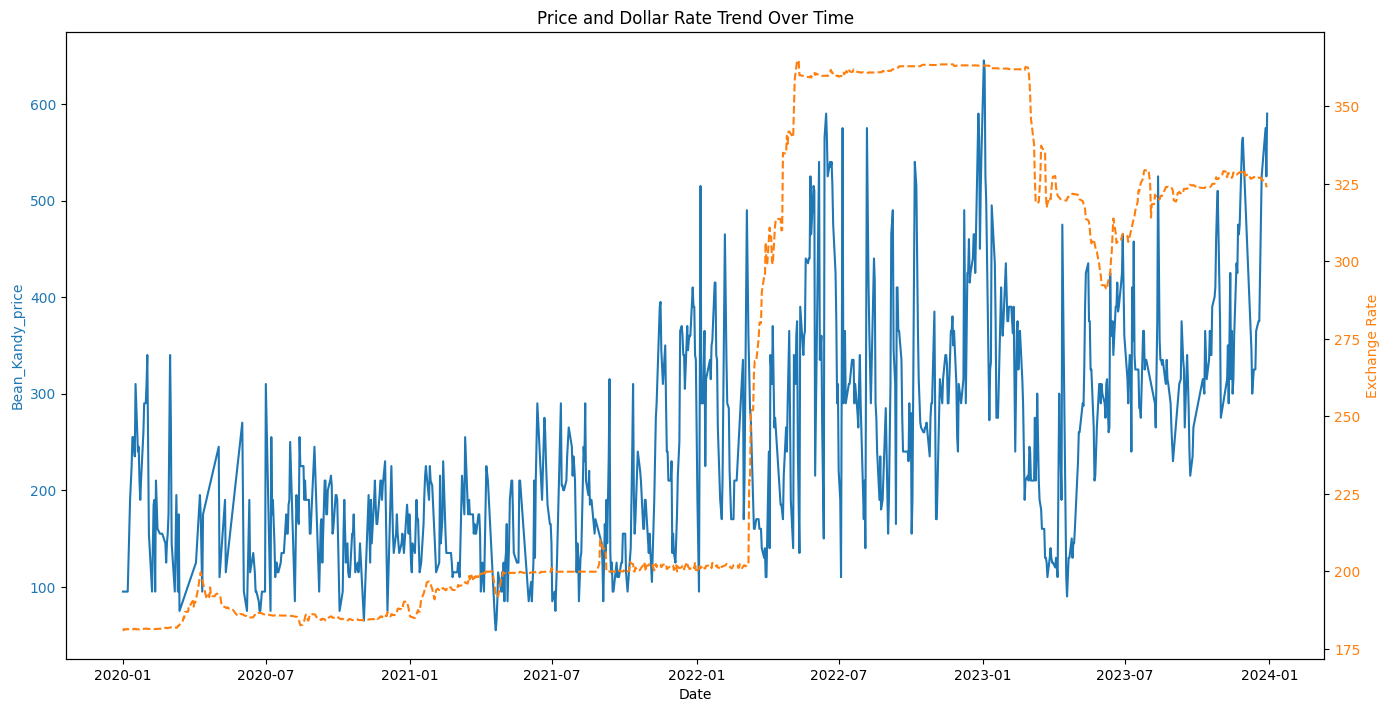

In [26]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(14, 7))

df = df_merged
# Plot price
ax1.set_xlabel('Date')
ax1.set_ylabel('Bean_Kandy_price', color='tab:blue')
ax1.plot(df.index, df['Bean_Kandy_price'], color='tab:blue', label='Bean_Kandy_price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for dollar rate
ax2 = ax1.twinx()
ax2.set_ylabel('Exchange Rate', color='tab:orange')
ax2.plot(df.index, df['Exchange Rate'], color='tab:orange', linestyle='--', label='Exchange Rate')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
fig.tight_layout()
plt.title('Price and Dollar Rate Trend Over Time')
plt.show()


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_dollar = MinMaxScaler(feature_range=(0, 1))

df['Bean_Kandy_price'] = scaler_price.fit_transform(df[['Bean_Kandy_price']])
df['Exchange Rate'] = scaler_dollar.fit_transform(df[['Exchange Rate']])

df=df[['Bean_Kandy_price','Exchange Rate']]
# Create training and testing datasets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]




In [28]:
import numpy as np
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Using the last 60 days to predict the next day's price
look_back = 60
X_train, y_train = create_dataset(train.values, look_back)
X_test, y_test = create_dataset(test.values, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))  # 2 features: price and dollar rate
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 2)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0460 - val_loss: 0.0241
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0142 - val_loss: 0.0258
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0139 - val_loss: 0.0240
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0111 - val_loss: 0.0089
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

In [31]:
# Predict using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions and actual values from scaled form back to original prices
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train_actual = scaler_price.inverse_transform([y_train])
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test_actual = scaler_price.inverse_transform([y_test])


from sklearn.metrics import mean_squared_error, mean_squared_log_error


y_test_actual_flat = y_test_actual.flatten()
test_predictions_flat = test_predictions.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual_flat, test_predictions_flat)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
y_test_actual_flat_safe = np.maximum(y_test_actual_flat, 1e-10)
test_predictions_flat_safe = np.maximum(test_predictions_flat, 1e-10)

rmsle = np.sqrt(mean_squared_log_error(y_test_actual_flat_safe, test_predictions_flat_safe))
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')
percentage_errors = np.abs((y_test_actual_flat - test_predictions_flat) / y_test_actual_flat) * 100

# Calculate mean percentage error
mean_percentage_error = np.mean(percentage_errors)
print(f'Mean Percentage Error (MPE): {mean_percentage_error:.2f}%')



35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error (MSE): 1289.8818685716317
Root Mean Squared Error (RMSE): 35.914925429013934
Root Mean Squared Logarithmic Error (RMSLE): 0.10155177760534187
Mean Percentage Error (MPE): 7.13%


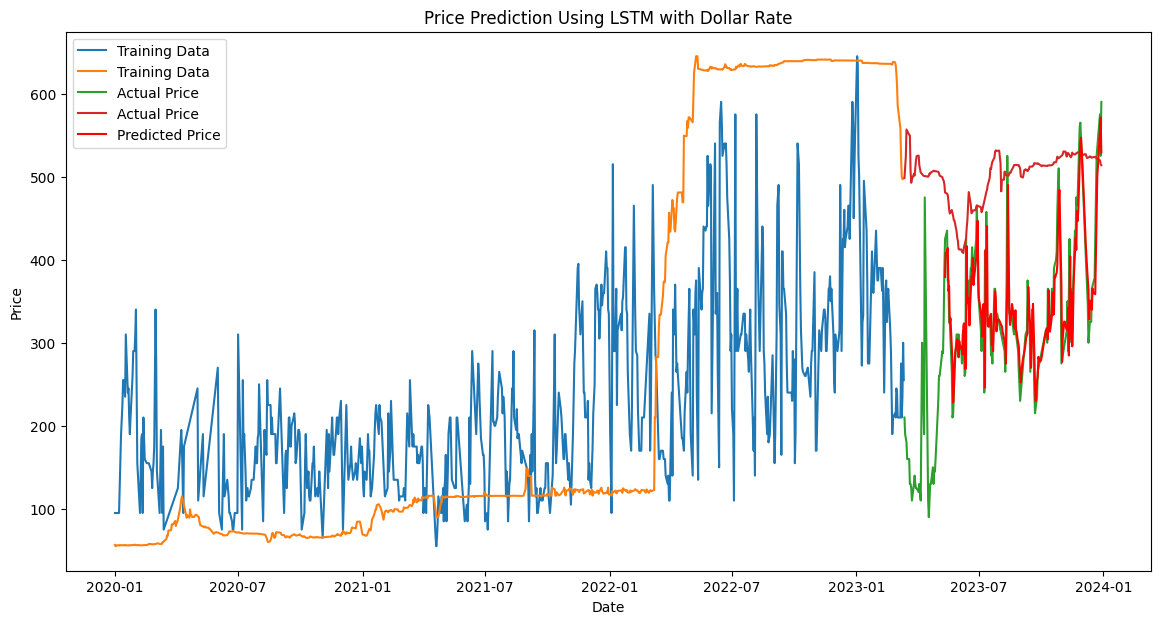

In [32]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
filtered_index_train = df.index[:train_size][df.index[:train_size] >= '2020-01-01']
filtered_index_test = df.index[train_size:][df.index[train_size:] >= '2020-01-01']
filtered_index_predictions = df.index[train_size+look_back:][df.index[train_size+look_back:] >= '2020-01-01']

plt.plot(filtered_index_train, scaler_price.inverse_transform(train.values), label='Training Data')
plt.plot(filtered_index_test, scaler_price.inverse_transform(test.values), label='Actual Price')
plt.plot(filtered_index_predictions, test_predictions, label='Predicted Price', color='red')

# filtered_index_train = df.index[:train_size][df.index[:train_size] >= '2020-01-01']
# filtered_index_test = df.index[train_size:][df.index[train_size:] >= '2020-01-01']
# filtered_index_predictions = df.index[train_size+look_back:][df.index[train_size+look_back:] >= '2020-01-01']

# plt.plot(filtered_index_train, scaler.inverse_transform(train.values[df.index[:train_size] >= '2020-01-01']), label='Training Data')
# plt.plot(filtered_index_test, scaler.inverse_transform(test.values[df.index[train_size:] >= '2020-01-01']), label='Actual Price')
# plt.plot(filtered_index_predictions, test_predictions[df.index[train_size+look_back:] >= '2020-01-01'], label='Predicted Price', color='red')

plt.title('Price Prediction Using LSTM with Dollar Rate')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (90,) and (30, 1)

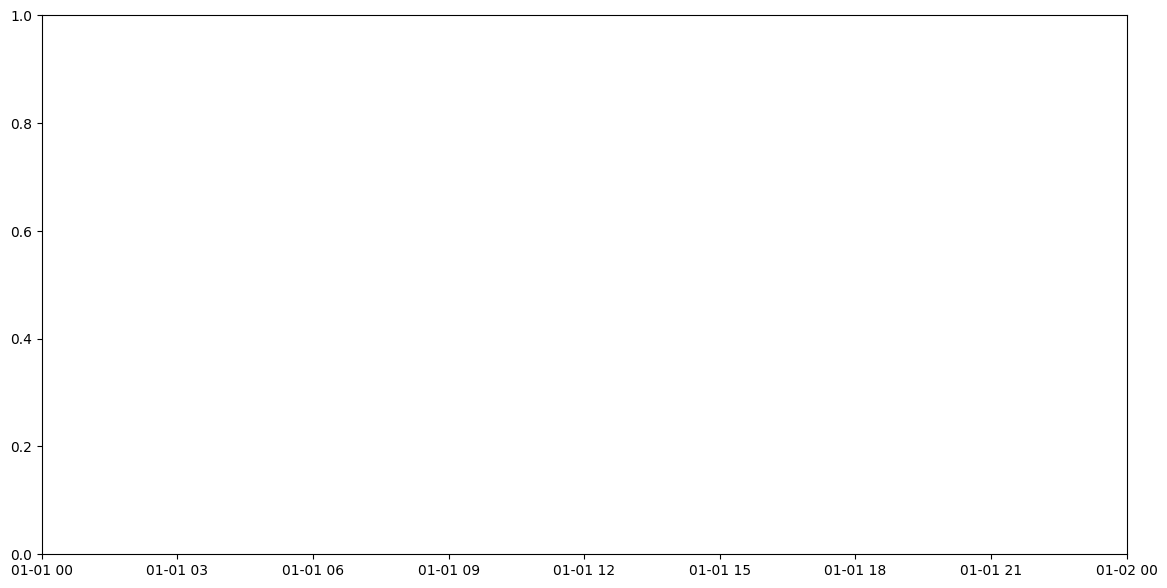

In [33]:
# Use the last part of the test set for prediction
last_sequence = df[-look_back:].values
forecast_input = last_sequence
forecast = []

# Forecast the next 90 days (approx. 3 months)
for _ in range(30):
    forecast_input_reshaped = np.reshape(forecast_input, (1, look_back, 2))
    next_price = model.predict(forecast_input_reshaped)
    forecast.append(next_price[0, 0])
    # Update the forecast input with the new forecasted price
    new_dollar_rate = forecast_input[-1, 1]  # assuming dollar rate remains constant
    forecast_input = np.append(forecast_input[1:], [[next_price[0, 0], new_dollar_rate]], axis=0)

# Invert the forecasted values to the original price scale
forecast = scaler_price.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot forecasted prices
future_dates = pd.date_range(start=df.index[-1], periods=90)
plt.figure(figsize=(14, 7))
plt.plot(future_dates, forecast, label='Forecasted Prices', color='green')
plt.title('3-Month Price Forecast Using LSTM with Dollar Rate')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
